In [86]:
from pandas import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.axes as axes
from itertools import product
import random
from scipy.stats import t, norm

import warnings
warnings.filterwarnings("ignore")


from arch import arch_model
import statsmodels.api as sm
import statsmodels.formula.api as smf



from pandas_datareader import data as web
import yfinance as yf
yf.pdr_override()

In [2]:
# load data on the CAC40, FTSE100, and the DAX.

# Fonction disponible dans web
# web.
# web.get_data_yahoo?

CAC40 = web.get_data_yahoo(tickers="^FCHI", start="2018-01-1", end="2022-08-31").reset_index()
CAC40['Name'] = 'CAC40' # name of the index

#DAX = web.get_data_yahoo(tickers='^GDAXI', start="2018-01-1", end="2022-08-31").reset_index()
#DAX['Name'] = 'DAX'  # name of the index

#FTSE = web.get_data_yahoo(tickers='^FTSE', start="2018-01-1", end="2022-08-31").reset_index()
#FTSE['Name'] = 'FTSE' # name of the index

data = DataFrame() # the overall dataframe

for db in [CAC40]: # append all the individual indices
	data = data.append(db,ignore_index=True)

###############################################################################
#data.to_csv(r'C:\Users\elaar\python_ATS\DataFromYahoo.csv', encoding = 'UTF-8', sep = ",")
###############################################################################
data.Date = pd.to_datetime(data.Date,utc=True)

[*********************100%***********************]  1 of 1 completed


C:\Users\elaar\AppData\Local\Temp\ipykernel_16116\2129614012.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(db,ignore_index=True)


In [3]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Name
0,2018-01-01 23:00:00+00:00,5318.740234,5318.740234,5258.660156,5288.600098,5288.600098,66802600,CAC40
1,2018-01-02 23:00:00+00:00,5295.310059,5347.629883,5291.890137,5331.279785,5331.279785,75371700,CAC40
2,2018-01-03 23:00:00+00:00,5360.009766,5430.720215,5360.009766,5413.689941,5413.689941,92583500,CAC40
3,2018-01-04 23:00:00+00:00,5424.160156,5470.750000,5422.779785,5470.750000,5470.750000,76275800,CAC40
4,2018-01-07 23:00:00+00:00,5483.470215,5499.149902,5478.919922,5487.419922,5487.419922,72318000,CAC40
...,...,...,...,...,...,...,...,...
1190,2022-08-23 22:00:00+00:00,6332.430176,6396.629883,6319.700195,6386.759766,6386.759766,52703400,CAC40
1191,2022-08-24 22:00:00+00:00,6432.160156,6440.689941,6361.529785,6381.560059,6381.560059,49495300,CAC40
1192,2022-08-25 22:00:00+00:00,6420.750000,6429.790039,6252.589844,6274.259766,6274.259766,67384400,CAC40
1193,2022-08-28 22:00:00+00:00,6199.109863,6232.250000,6153.439941,6222.279785,6222.279785,54873600,CAC40


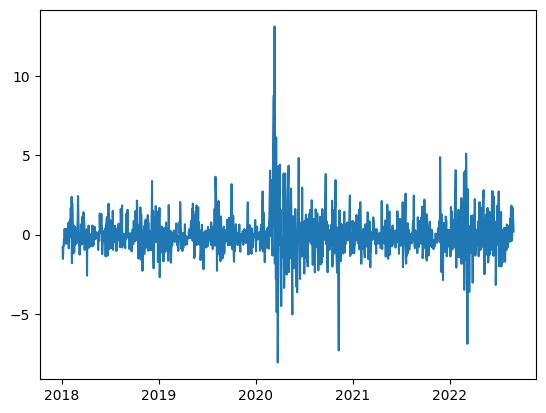

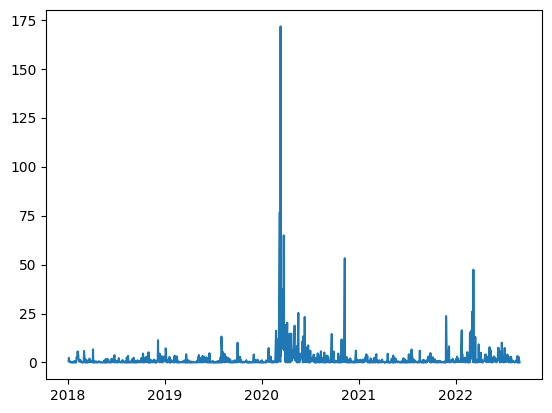

In [4]:
data['log_return'] = 100*(np.log(data["Adj Close"].shift(1)) - np.log(data["Adj Close"]))
data['sq_return'] = data.log_return.mul(data.log_return)
data['dt'] = ((data.Date - data.Date.shift(1))).dt.days.cumsum()

plt.plot(data.Date,data.log_return)
plt.show()
plt.plot(data.Date,data.sq_return)
plt.show()

In [5]:
pre_covid = data[data.Date <= '2020-01-31']
post_covid = data[data.Date >= '2020-01-31']

#===========================================================================
# calc log diff, select in_sample, select out_sample
#===========================================================================

total_obs = 1000 
log_returns = data.log_return

log_returns        = log_returns.iloc[1: total_obs + 21]
log_returns_in     = log_returns.iloc[: total_obs]
log_returns_out    = log_returns.iloc[total_obs: 1021]

In [6]:
sm.tsa.stattools.adfuller(np.ravel(log_returns_in), regression='ct', autolag='BIC', store=False, regresults=True)

(-11.02604304387219,
 1.9864080113117966e-17,
 {'1%': -3.9679251346628828,
  '5%': -3.414925035261852,
  '10%': -3.129660463100453},
 <statsmodels.stats.diagnostic.ResultsStore at 0x29d74dd1700>)

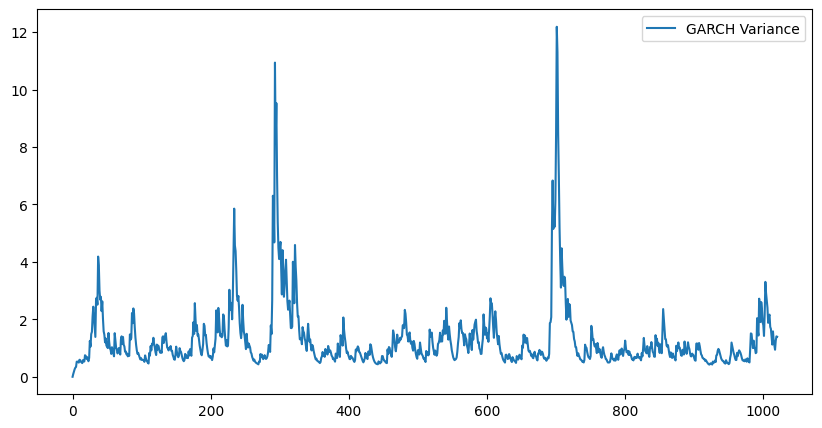

In [77]:
#Simulating Vol in garch 
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return variance

# Simulate a GARCH series given our results above
garch_variance = simulate_GARCH(n= 1021, omega = 0.0985, alpha = 0.2055, 
                                             beta = 0.7319)

garch_variance = pd.DataFrame(garch_variance)
garch_variance_in = garch_variance[:1000]
garch_variance_out = garch_variance[1000:1021]

# Plot the ARCH variance
plt.figure(figsize=(10,5))


# Plot the GARCH variance
plt.plot(garch_variance, label = 'GARCH Variance')
plt.legend()
plt.show()

In [76]:
# Vol forecasting recursive window
print('vol forecasting recursive window')
forecast = []

for dt in garch_variance_out.index:
    _data = garch_variance.loc[garch_variance.index < dt]
    
    model_vol = arch_model(_data, vol="GARCH", p=1, q=1).fit(disp="off")
    forecast.append(model_vol.forecast().variance.dropna().values[0][0])
    
forecast = pd.DataFrame(forecast, columns=['vol recursive'], index=garch_variance_out.index)/10 #/10 car valeurs trop elevées, j'ai l'impression que c'est en unités au lieu que ce soit en pourcentage
garch_variance_in = np.append(garch_variance_in,forecast)
garch_variance_in

vol forecasting recursive window


array([0.        , 0.0985    , 0.1756516 , ..., 0.00580183, 0.01812799,
       0.03232135])

In [78]:
model = arch_model(log_returns_in, mean="AR", vol="GARCH", p=1, q=1)
ar_garch_model = model.fit(disp="off")
ar_garch_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1435.03
Distribution:                  Normal   AIC:                           2878.05
Method:            Maximum Likelihood   BIC:                           2897.68
                                        No. Observations:                 1000
Date:                Thu, Dec 22 2022   Df Residuals:                      999
Time:                        14:07:24   Df Model:                            1
                                 Mean Model                                
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
Const         -0.0809  2.970e-02     -2.723  6.477e-03 [ -0.139,-2.265e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.0985  3.185e-02      3.092  1.989e-03 [3.604e-02,  0.161]
alpha[1]       0.2055  5.904e-02      3.481  4.999e-04 [8.979e-02,  0.321]
beta[1]        0.7319  5.121e-02     14.292  2.453e-46   [  0.632,  0.832]
==========================================================================

Covariance estimator: robust
"""

In [8]:
# Use the fitted model to make forecasts

ar_garch_forecast_brut = ar_garch_model.forecast(horizon=20,reindex=False)
random_value = random.gauss(ar_garch_forecast_brut.mean.values[0], np.sqrt(ar_garch_forecast_brut.variance.values[0]))
ar_garch_forecast = (random_value / random_value.mean())-1
print(ar_garch_forecast)

forecast = pd.DataFrame(list(ar_garch_forecast), columns=['fixed'], index=log_returns_out.index)
ar_garch_forecast_total = np.append(log_returns_in, forecast)
ar_garch_forecast_total


[ 0.15897818  0.1372858   0.11654757  0.09673144  0.07780603  0.05974055
  0.04250482  0.02606928  0.01040495 -0.00451657 -0.01872309 -0.03224182
 -0.0450994  -0.05732187 -0.06893466 -0.07996262 -0.09042998 -0.10036036
 -0.10977675 -0.11870152]


array([-0.80377401, -1.53396006, -1.04847988, ..., -0.10036036,
       -0.10977675, -0.11870152])

In [9]:
# recursive window
print('forecasting recursive window')
forecast = []

for dt in log_returns_out.index:
    _data = log_returns.loc[log_returns.index < dt]
    
    model = arch_model(_data, mean="AR", vol="GARCH", p=1, q=1).fit(disp="off")
    ar_garch_forecast_brut = ar_garch_model.forecast(horizon=1,reindex=False)
    random_value = random.gauss(ar_garch_forecast_brut.mean.values[0], np.sqrt(ar_garch_forecast_brut.variance.values[0]))
    forecast.append(random_value)

forecast = pd.DataFrame(forecast, columns=['recursive'], index=log_returns_out.index)/10 #/10 car valeurs trop elevées, j'ai l'impression que c'est en unités au lieu que ce soit en pourcentage
ar_garch_forecast_recursive = np.append(log_returns_in, forecast)
ar_garch_forecast_recursive

forecasting recursive window


array([-0.80377401, -1.53396006, -1.04847988, ...,  0.22209913,
        0.03011928,  0.04962169])

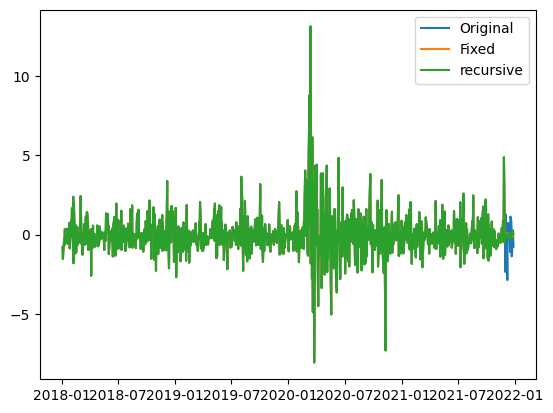

In [10]:
# Plot the original time series and the predictions: comparing log returns
plt.plot(data["Date"].iloc[1: total_obs + 21], log_returns, label="Original")
plt.plot(data["Date"].iloc[1: total_obs + 21], ar_garch_forecast_total, label="Fixed")
plt.plot(data["Date"].iloc[1: total_obs + 21], ar_garch_forecast_recursive, label="recursive")

plt.legend()
plt.show()

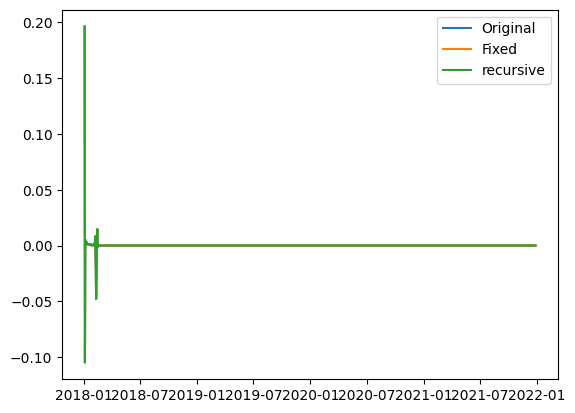

In [11]:
# Plot the original time series and the predictions: comparing cumulative product of the log returns
plt.plot(data["Date"].iloc[1: total_obs + 21], (1 + log_returns).cumprod(), label="Original")
plt.plot(data["Date"].iloc[1: total_obs + 21], (1 + ar_garch_forecast_total).cumprod(), label="Fixed")
plt.plot(data["Date"].iloc[1: total_obs + 21], (1 + ar_garch_forecast_recursive).cumprod(), label="recursive")

plt.legend()
plt.show()

C:\Users\elaar\AppData\Local\Temp\ipykernel_16116\2427922321.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(data["Date"].iloc[total_obs+1: total_obs + 21], log_returns[total_obs:], label="Original")


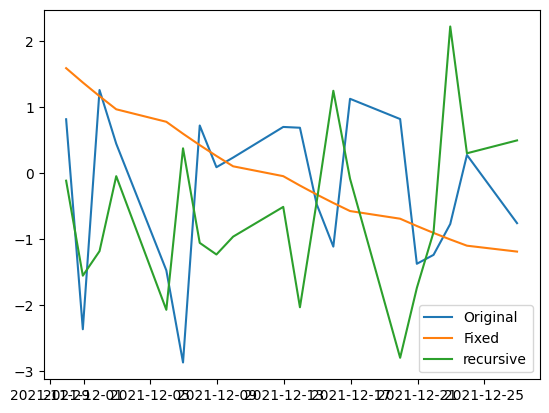

In [13]:
# Plot the original time series and the predictions: comparing cumulative product of the log returns
plt.plot(data["Date"].iloc[total_obs+1: total_obs + 21], log_returns[total_obs:], label="Original")
plt.plot(data["Date"].iloc[total_obs+1: total_obs + 21], ar_garch_forecast_total[total_obs:]*10, label="Fixed")
plt.plot(data["Date"].iloc[total_obs+1: total_obs + 21], ar_garch_forecast_recursive[total_obs:]*10, label="Recursive")

plt.legend()
plt.show()

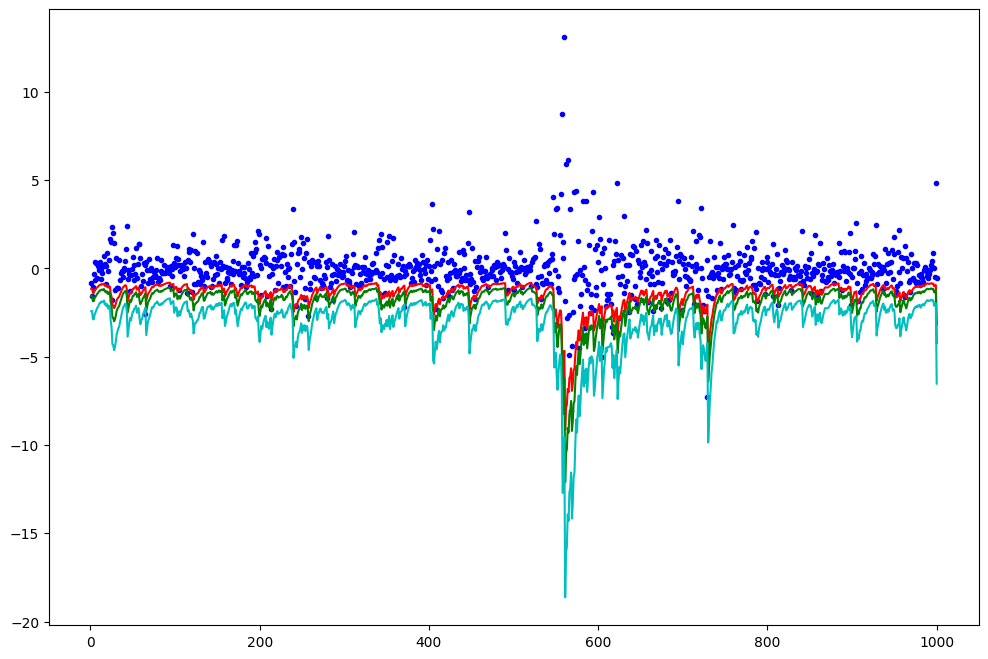

log_returns_in < var90  :   0.542
log_returns_in < var95  :   0.54
log_returns_in < var99  :   0.537


In [130]:
#===========================================================================
# Value-at-Risk estimates for the in-sample data
#===========================================================================


res = arch_model(log_returns_in, mean="AR", vol="GARCH", p=1, q=1).fit(disp="off")
temp = res.conditional_volatility

var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure(figsize=(12,8))
plt.plot(log_returns_in.index,log_returns_in, 'b.')

#var in percentage points
plt.plot(log_returns_in.index, var90*100, 'r-')
plt.plot(log_returns_in.index, var95*100, 'g-')
plt.plot(log_returns_in.index, var99*100, 'c-')
plt.show()

print("log_returns_in < var90  :  ",np.mean(log_returns_in < var90))  
print("log_returns_in < var95  :  ",np.mean(log_returns_in < var95)) 
print("log_returns_in < var99  :  ",np.mean(log_returns_in < var99))

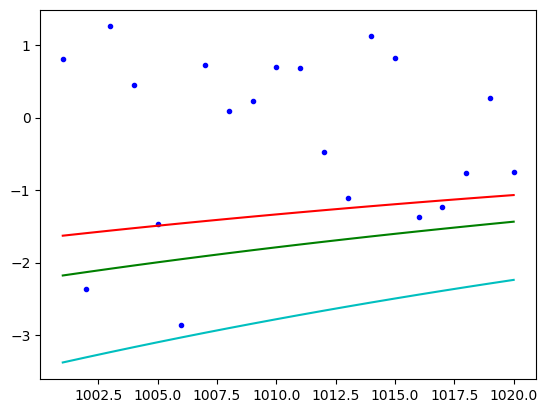

log_returns_out < var90  :   0.45
log_returns_out < var95  :   0.45
log_returns_out < var99  :   0.45
11


In [129]:
#===========================================================================
# Value-at-Risk estimates for the out of sample data
#===========================================================================


res = arch_model(log_returns_out, mean="AR", vol="GARCH", p=1, q=1).fit(disp="off")
temp = res.conditional_volatility

var90 = (0.0656 + res.conditional_volatility * t.ppf(0.10,9.2571)) /100
var95 = (0.0656 + res.conditional_volatility * t.ppf(0.05,9.2571)) /100
var99 = (0.0656 + res.conditional_volatility * t.ppf(0.01,9.2571)) /100
    
fig = plt.figure()
plt.plot(log_returns_out.index,log_returns_out, 'b.')

#var in percentage points
plt.plot(log_returns_out.index, var90*100, 'r-')
plt.plot(log_returns_out.index, var95*100, 'g-')
plt.plot(log_returns_out.index, var99*100, 'c-')
plt.show()

print("log_returns_out < var90  :  ", np.mean(log_returns_out < var90))  
print("log_returns_out < var95  :  ",np.mean(log_returns_out < var95)) 
print("log_returns_out < var99  :  ",np.mean(log_returns_out < var99))
print(np.sum(log_returns_out>abs(var99)))

Que du testing down below

In [53]:
#"y ~ x + np.power(x, 2)"
model_eq = data.dt + np.power(data.dt,2)
model = smf.ols("data.log_return ~ data.log_return.shift(1) + data.dt + np.power(data.dt, 2) ",data)
results = model.fit()

# Print the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        data.log_return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1246
Date:                Tue, 20 Dec 2022   Prob (F-statistic):              0.946
Time:                        13:41:30   Log-Likelihood:                -2015.0
No. Observations:                1193   AIC:                             4038.
Df Residuals:                    1189   BIC:                             4058.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [20]:
model = arch_model(log_returns_in, mean="AR", vol="GARCH", p=1, q=1)
model.volatility.forecast()


TypeError: forecast() missing 4 required positional arguments: 'parameters', 'resids', 'backcast', and 'var_bounds'

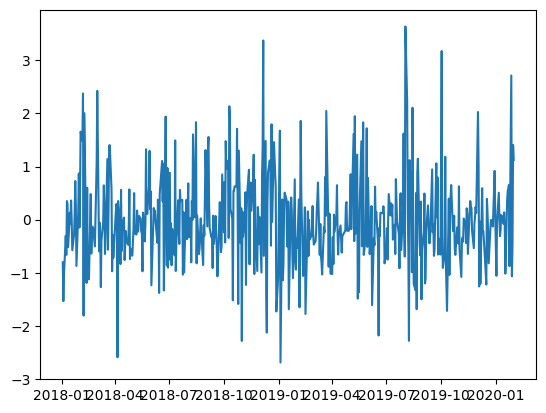

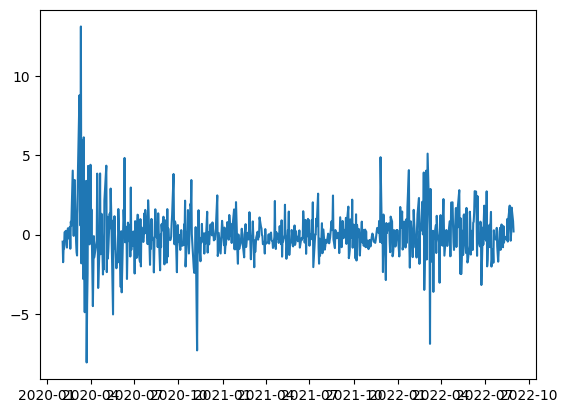

In [32]:
plt.plot(pre_covid.Date, pre_covid.log_return)
plt.show()
plt.plot(post_covid.Date, post_covid.log_return)
plt.show()

c:\Users\elaar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


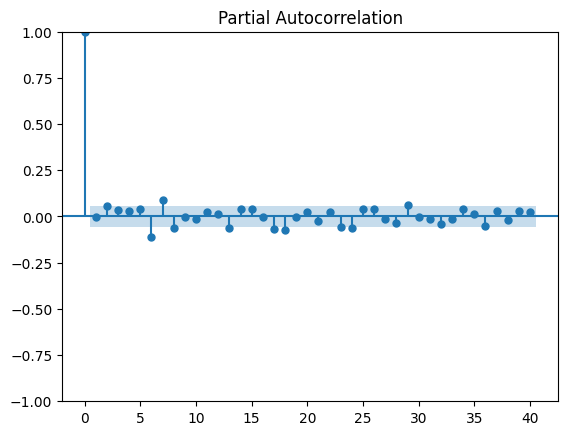

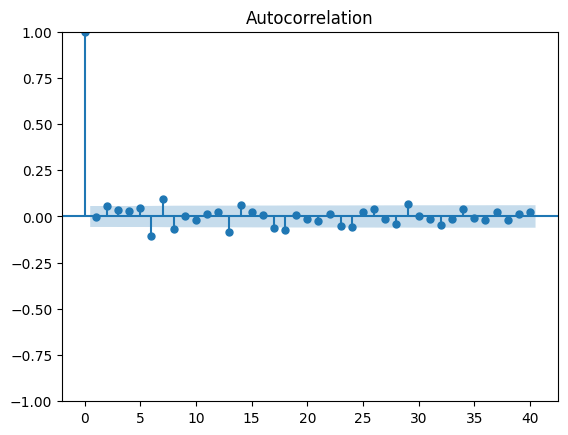

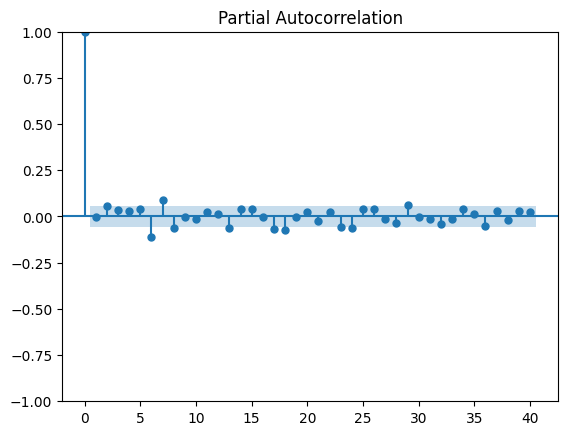

In [33]:
sm.graphics.tsa.plot_acf(data.log_return[1:], lags=40)
sm.graphics.tsa.plot_pacf(data.log_return[1:], lags=40)
#-> we find that we most likely have an ARMA(1,1), we'll test for other p and q values.

In [15]:
ts = sm.tsa.arima.ARIMA(np.ravel(log_returns), order=(2,0,1))
results_arma_2_1 = ts.fit()
results_arma_2_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1020
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -1688.941
Date:                Wed, 21 Dec 2022   AIC                           3387.882
Time:                        16:01:30   BIC                           3412.520
Sample:                             0   HQIC                          3397.237
                               - 1020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0301      0.050     -0.599      0.549      -0.129       0.068
ar.L1          0.3643      0.120      3.041      0.002       0.130       0.599
ar.L2          0.0991      0.017      5.915      0.000       0.066       0.132
ma.L1         -0.3689      0.122     -3.024      0.002      -0.608      -0.130
sigma2         1.6060      0.030     53.507      0.000       1.547       1.665
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10211.83
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.53   Skew:                             1.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [148]:
date_start = log_returns_out.index[0]
date_end = log_returns_out.index[-1]
forecasts = []
idx = log_returns_out.index
data_shifted = data.shift(1).loc[idx]
    
# estimate all
print('\nforecasting fixed')
arma_model  = sm.tsa.arima.ARIMA(np.ravel(log_returns_in), order=(2,0,1)).fit() #tsa.ARMA(data_difflog_in, order=order).fit(method='mle', maxiter=100, disp=-1)
arma_model.forecast(10)


forecasting fixed


array([ 0.46999563,  0.10326024,  0.07412887,  0.0250959 ,  0.00403686,
       -0.00882487, -0.01575121, -0.01964016, -0.02179286, -0.02299021])

In [133]:
y_pred = results_arma_2_1.predict()[:196]
print(data.log_return.iloc[:1000].to_list().append(list(y_pred)))



None


,y_pred
999,0.013568
1000,0.013568
1001,0.009553
1002,0.055064
1003,0.125046
...,...
1190,0.071152
1191,-0.014765
1192,0.019358
1193,-0.032998


In [35]:
y_pred = results_arma_2_1.predict()
"""last = y_pred[-1]
y_pred_complement = pd.DataFrame(np.tile(0,(len(data.log_return) - len(y_pred),1)),
                   columns=["y_pred"])

y_pred = np.append(y_pred,y_pred_complement)"""
data["y_pred"] = y_pred

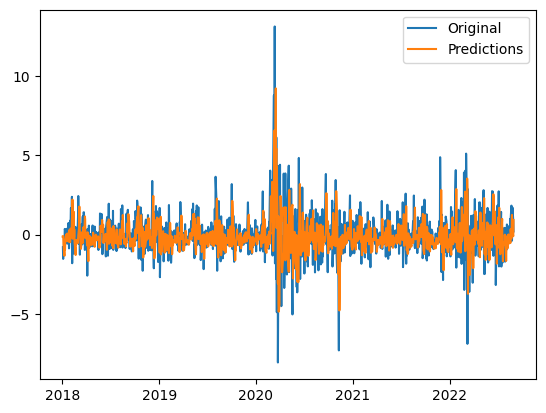

In [36]:


# Plot the original time series and the predictions
plt.plot(data["Date"], data["log_return"], label="Original")
plt.plot(data["Date"], data["y_pred"]*10, label="Predictions")
plt.legend()
plt.show()



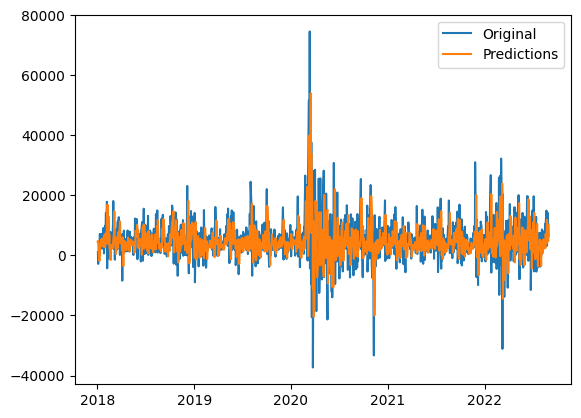

In [50]:
t = 5288.600098 * (1 + 10*data["y_pred"])
s = 5288.600098 * (1 + data["log_return"])

plt.plot(data["Date"], s, label="Original")
plt.plot(data["Date"], t, label="Predictions")
plt.legend()
plt.show()



In [43]:
data["Adj Close"]

0       5288.600098
1       5331.279785
2       5413.689941
3       5470.750000
4       5487.419922
           ...     
1190    6386.759766
1191    6381.560059
1192    6274.259766
1193    6222.279785
1194    6210.220215
Name: Adj Close, Length: 1195, dtype: float64

In [115]:


n_autocor = 40
acf_coef = np.zeros((n_autocor+1))
lb = np.zeros((n_autocor))
lb_p = np.zeros((n_autocor))
ts = pre_covid.log_return
acf_coef = sm.tsa.stattools.acf(pre_covid.log_return[1:],nlags=40)
temp_acf_coef = acf_coef[1:acf_coef.shape[0]]
lb[:], lb_p[:] = sm.tsa.stattools.q_stat(temp_acf_coef, len(pre_covid.index))

np.mean(lb_p)<0.05 # false -> we do not reject the null: no autocorrelation 



False

In [130]:
# The null hypothesis of the ADF is that there is a unit root, with the alternative that there is no unit root. 
# If the pvalue is above a critical size, then we cannot reject that there is a unit root.
sm.tsa.stattools.adfuller(np.ravel(pre_covid.log_return[1:]), regression='ctt', autolag='BIC', store=False, regresults=True)

(-34.67490089495259,
 0.0,
 {'1%': -4.380868859191798,
  '5%': -3.8373491387370486,
  '10%': -3.556331317159972},
 <statsmodels.stats.diagnostic.ResultsStore at 0x220e55ab9d0>)

In [56]:
import  statsmodels.tsa.arima_model as arima
ts = np.ravel(pre_covid.log_return[1:])

ar_order = [0, 1, 2, 3]
ma_order = [0, 1, 2, 3]
arma_res = [list(orders) for orders in product(ar_order, ma_order)]
#     pprint.pprint(arma_res)

# sm.tsa.arima.model.ARIMA
for order in arma_res:
    print('fitting: ar:{} - ma:{}'.format(*order)) 
    try:
        arma_model  = sm.tsa.arima.ARIMA(ts, order=order).fit(method='mle', disp=-1)
        order.extend([arma_model.aic / 1e3, arma_model.bic / 1e3])
    except Exception as exception:
        print(exception.__str__())
        order.extend([np.NaN, np.NaN])

fitting: ar:0 - ma:0
`order` argument must be an iterable with three elements.
fitting: ar:0 - ma:1
`order` argument must be an iterable with three elements.
fitting: ar:0 - ma:2
`order` argument must be an iterable with three elements.
fitting: ar:0 - ma:3
`order` argument must be an iterable with three elements.
fitting: ar:1 - ma:0
`order` argument must be an iterable with three elements.
fitting: ar:1 - ma:1
`order` argument must be an iterable with three elements.
fitting: ar:1 - ma:2
`order` argument must be an iterable with three elements.
fitting: ar:1 - ma:3
`order` argument must be an iterable with three elements.
fitting: ar:2 - ma:0
`order` argument must be an iterable with three elements.
fitting: ar:2 - ma:1
`order` argument must be an iterable with three elements.
fitting: ar:2 - ma:2
`order` argument must be an iterable with three elements.
fitting: ar:2 - ma:3
`order` argument must be an iterable with three elements.
fitting: ar:3 - ma:0
`order` argument must be an ite

In [ ]:
sm.tsa.arima.ARIMA(np.ravel(pre_covid.log_return[1:]), (1,1)).fit(method='mle', disp=-1)

In [121]:
model_garch_1_1 = arch_model(pre_covid.log_return[1:],mean ="constant",vol="GARCH", p=1, q=1)
results_garch_1_1 = model_garch_1_1.fit()
results_garch_1_1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4878.058981432727
Iteration:      2,   Func. Count:     14,   Neg. LLF: 95203.41790854144
Iteration:      3,   Func. Count:     21,   Neg. LLF: 700.6326995148328
Iteration:      4,   Func. Count:     27,   Neg. LLF: 736.4521453655909
Iteration:      5,   Func. Count:     34,   Neg. LLF: 660.6507407715753
Iteration:      6,   Func. Count:     40,   Neg. LLF: 252535213.14786273
Iteration:      7,   Func. Count:     46,   Neg. LLF: 689.8630386640699
Iteration:      8,   Func. Count:     52,   Neg. LLF: 650.4905611441972
Iteration:      9,   Func. Count:     57,   Neg. LLF: 650.4297253148968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 650.4278159869289
Iteration:     11,   Func. Count:     67,   Neg. LLF: 650.4277950224995
Iteration:     12,   Func. Count:     72,   Neg. LLF: 650.4277906525931
Iteration:     13,   Func. Count:     76,   Neg. LLF: 650.4277906525731
Optimization terminated successfully    (Exit mode 0)
         

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -650.428
Distribution:                  Normal   AIC:                           1308.86
Method:            Maximum Likelihood   BIC:                           1325.95
                                        No. Observations:                  531
Date:                Sat, Dec 03 2022   Df Residuals:                      530
Time:                        21:07:47   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0801  3.522e-02      2.274  2.297e-02 [1.106e-02,  0.149]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1191  3.762e-02      3.164  1.554e-03 [4.531e-02,  0.193]
alpha[1]       0.2122  7.772e-02      2.730  6.338e-03 [5.983e-02,  0.365]
beta[1]        0.6431  7.420e-02      8.667  4.427e-18   [  0.498,  0.789]
==========================================================================

Covariance estimator: robust
"""

## Data collection from ECB Db

In [6]:
########################################   doesnt work have to debug ########################################
# https://pandasdmx.readthedocs.io/en/v0.2.2dev/usage.html

import pandas as pd
import matplotlib.pyplot as plt
from pandasdmx import Request

# Define the source
ecb = Request('ECB')

import collections
temp_list = collections.OrderedDict.fromkeys(['B.U2.EUR.4F.G_N_A.SV_C_YM.SR_3M', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_6M', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_9M', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_1Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_2Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_3Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_4Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_5Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_6Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_7Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_8Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_9Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_10Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_11Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_12Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_13Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_14Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_15Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_16Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_17Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_18Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_19Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_20Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_21Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_22Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_23Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_24Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_25Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_26Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_27Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_28Y', 'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_29Y',
             'B.U2.EUR.4F.G_N_A.SV_C_YM.SR_30Y'])
type(temp_list)

ts_YC_merge_col = pd.DataFrame()
for x in temp_list :
    print(x)
    data_response_YC = ecb.data(resource_id = 'YC', key=x, params = {'startPeriod': '2004-01-01', 'endPeriod':'2021-06-30'})
    data_YC = data_response_YC.data
    print(type(data_YC))
    monthly = (s for s in data_YC if s.key.FREQ == 'B')
    ts_YC = data_response_YC.write(monthly)
    ts_YC.columns = [x[-5:]]
    ts_YC_merge_col = pd.concat([ts_YC_merge_col,ts_YC], axis=1)

# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r'C:\Users\elaar\python_ATS\ECB_SpotRates.xlsx', engine='xlsxwriter')
# Convert the dataframe to an XlsxWriter Excel object.
ts_YC_merge_col.to_excel(writer, sheet_name='Data')
# Close the Pandas Excel writer and output the Excel file.
writer.save()
###

###############################################################################

#récupérer les données dans Data
Data = pd.ExcelFile(r'C:\Users\elaar\python_ATS\ECB_SpotRates.xlsx')
Data = Data.parse("Data")
# or
# Data = pd.read_excel('F:/Dropbox/Dauphine-SDFi/Annees_18-19/AppliedTimeSeries_Master203/Exam_2021/ECB_SpotRates.xlsx',sheet_name='Data')

#Mise en place des dates comme index
Data = Data.set_index('TIME_PERIOD')

B.U2.EUR.4F.G_N_A.SV_C_YM.SR_3M
<class 'list'>


AttributeError: 'DataMessage' object has no attribute 'write'